### Import required modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import concurrent

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

### Define the file location

In [7]:
file_path = r"C:\Users\lukas\OneDrive - University of Cambridge\PhD\3DMOKE\MagnetCalibration\magnet_response_complete.h5"
print(os.path.isfile(file_path))
out_folder = 'all_poles_results'
try:
    os.stat(out_folder)
except:
    os.mkdir(out_folder) 

True


# Fit magnet hysteresis

### Extract and preprocess the data

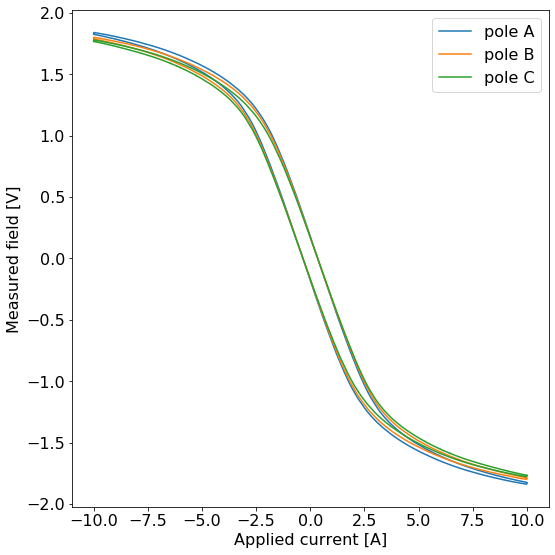

In [8]:
poles = [0, 1, 2]
poles_dict = {0:'A', 1:'B', 2:'C'}
nnl_all = []
plt.figure(figsize=(8, 8))
for pole in poles:
    with h5py.File(file_path, 'r') as f:
        nnl_hp = pd.DataFrame(f['nonlinear_response/pole{}/hallprobe/data'.format(pole)][:])
        nnl_hx = pd.DataFrame(f['nonlinear_response/pole{}/hexapole/data'.format(pole)][:])
    bins = np.arange(nnl_hp[0].iloc[0], nnl_hp[0].iloc[-1], 1/100)

    nnl_hp['bins'] = pd.cut(nnl_hp[0], bins, right=False)
    nnl_hp = nnl_hp.groupby('bins').mean().reset_index().drop(labels=[0,'bins'], axis=1)
    nnl_hp.columns = ['hpA', 'hpB', 'hpC']
    nnl_hx['bins'] = pd.cut(nnl_hx[0], bins, right=False)
    nnl_hx = nnl_hx.groupby('bins').mean().reset_index().drop(labels=[0,'bins'], axis=1)
    nnl_hx.columns = ['hxA', 'hxB', 'hxC']

    nnl = pd.concat([nnl_hp, nnl_hx], axis=1)

    # add the negative values for completion
    nnl = pd.concat([nnl, -nnl])
    # add to the list
    nnl_all.append(nnl.copy())

    plt.plot(nnl['hx'+poles_dict[pole]], nnl['hp'+poles_dict[pole]], label='pole '+poles_dict[pole])
    plt.xlabel('Applied current [A]')
    plt.ylabel('Measured field [V]')
#     plt.title('Pole {} hysteresis'.format(poles_dict[pole]))

plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(out_folder, 'Magnet hysteresis.png'))

### Fit the data

Pole A coefficients:
 [-0.11431185  0.          0.15528954  0.         -0.29578994  0.
 -1.83921101  0.        ]
Pole B coefficients:
 [-0.1364662   0.          0.1893485   0.         -0.32750949  0.
 -1.88586746  0.        ]
Pole C coefficients:
 [-0.13754719  0.          0.17260889  0.         -0.35769612  0.
 -1.91392444  0.        ]


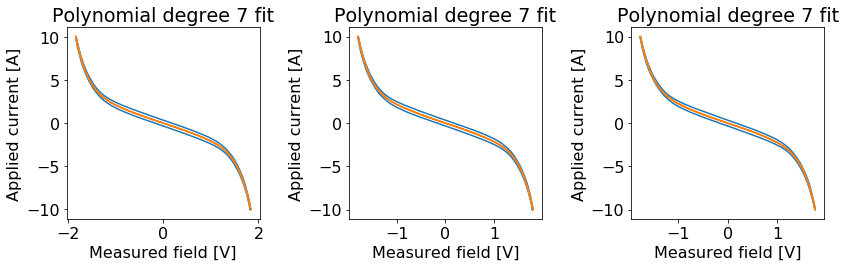

In [9]:
hyst_functions = []
hyst_coeffs = []
plt.figure(figsize=(12, 4))
for pole in poles:
    x = nnl_all[pole]['hp'+poles_dict[pole]].values
    y = nnl_all[pole]['hx'+poles_dict[pole]].values

    coeff = np.polyfit(x, y, 7)
    # set the even power terms to 0 (they have to be due to symmetry)
    coeff[1::2] = 0
    hyst_fun = np.poly1d(coeff)
    
    print('Pole {} coefficients:\n'.format(poles_dict[pole]), coeff)
    
    hyst_coeffs.append(coeff)
    hyst_functions.append(hyst_fun)

    plt.subplot(1, 3, pole+1)
    plt.plot(x, y, label='Measurement')
    plt.plot(x, hyst_functions[pole](x), label='Fit')
    plt.ylabel('Applied current [A]')
    plt.xlabel('Measured field [V]')
    plt.title('Polynomial degree 7 fit')
    
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'Magnet hysteresis fit.png'))

# Fit frequency-amplitude

### Extract the data

In [15]:
def extract_max_amp(data, invert_fun=None, timestep=1/10000):
    """Extracts the frequency from the loops experiment given the instrument group.
        Returns an array frequency, max amp, phase
    """
    if invert_fun is not None:
        data = invert_fun(data)
    
    # extract fft
    n = data.shape[0]
    fft = np.fft.rfft(data, axis=0) / (n / 2)
    fft_phase = np.angle(fft)
    fft_amp = np.absolute(fft)
    freq = np.fft.rfftfreq(n, d=timestep)
    
    # get the maximum amplitude
    indx = np.unravel_index(np.argmax(fft_amp, axis=None), fft_amp.shape)
    
    return np.array([freq[indx[0]], fft_amp[indx], fft_phase[indx]])

def extract_loop_data(grp, instrument):
    data = np.vstack([grp[key][instrument]['data'][:] for key in grp.keys()])
    return data


def get_frequency_data(file_path, pole='0'):
    """Gets the fourier data from the frequency response experiment for the given pole of the magnet given the file path"""
    instruments=['hallprobe', 'hexapole']
#     data_out = pd.DataFrame(columns=['hx_freq', 'hx_amp', 'hx_phase', 'hp_freq', 'hp_amp', 'hp_phase'])
    data = {key:[] for key in instruments}
    with h5py.File(file_path, 'r') as f:
        grp_loops = f['frequency_response/pole'+pole]
        n_loops = len(grp_loops.keys())
        for i, loops in enumerate(grp_loops.keys()):
#             print('Loop {}/{}'.format(i, n_loops))
            for inst in instruments:
                # get the data for the instrument
                loop_data = extract_loop_data(grp_loops[loops], inst)
                # get the max amplitude
                invert_fun = hyst_fun if inst=='hallprobe' else None
                max_amp = extract_max_amp(loop_data[:, 1:], invert_fun=invert_fun, timestep = loop_data[1, 0]-loop_data[0, 0])
                data[inst].append(max_amp)
    for inst in data:
        data[inst] = np.vstack(data[inst])
    
    return data

def format_freq_data(freq_data):
    """Formats the data and gets rid of the non matching data"""
    data_out = pd.DataFrame(np.hstack((freq_data['hexapole'], freq_data['hallprobe'])), 
                            columns=['hx_freq', 'hx_amp', 'hx_phase', 'hp_freq', 'hp_amp', 'hp_phase'])
    # make sure that all of the data matches (i.e. hallprobe and hexapole frequencies corresponse)
    freq_delta = np.abs(data_out['hx_freq'] - data_out['hp_freq'])
    print('There are {} data points where frequencies do not match.'.format(np.sum(freq_delta>=1/100)))
    data_out = data_out.loc[freq_delta<1/100, :]
    # drop one of the frequencies and calculate the phase delta
    data_out.drop(columns='hp_freq', inplace=True)
    data_out.rename(columns={'hx_freq':'freq'}, inplace=True)
    data_out['phase_delta'] = (data_out['hp_phase'] - data_out['hx_phase'])%(2*np.pi)
    
    return data_out

def get_formatted_data(file_path, pole):
    data = get_frequency_data(file_path, pole=str(pole))
    return format_freq_data(data)
    
    
import traceback
freq_data = [None]*3
# get_data_proxy = lambda p: get_formatted_data(file_path, p)
# for pole in poles:
#     freq_data[pole] = get_data_proxy(pole)
with concurrent.futures.ThreadPoolExecutor() as executor:
    get_data_proxy = lambda p: get_formatted_data(file_path, p)
    for pole, result in zip(poles, executor.map(get_data_proxy, poles)):
        freq_data[pole] = result
print('Done!')

There are 0 data points where frequencies do not match.
There are 0 data points where frequencies do not match.
There are 0 data points where frequencies do not match.
Done!


### Plot the data for visualisation

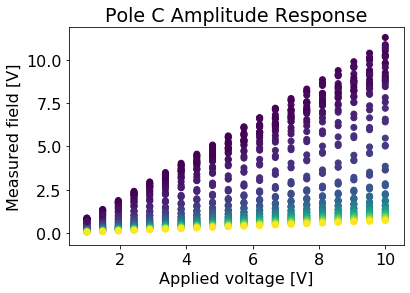

In [21]:
for pole in poles:
    plt.scatter(freq_data[pole]['hx_amp'], freq_data[pole]['hp_amp'], c=freq_data[pole]['freq'])
    plt.xlabel('Applied voltage [V]')
    plt.ylabel('Measured field [V]')
    plt.title('Pole {} Amplitude Response'.format(poles_dict[pole]))
    plt.savefig(os.path.join(out_folder, 'Amplitude_response_pole{}.png'.format(poles_dict[pole])))

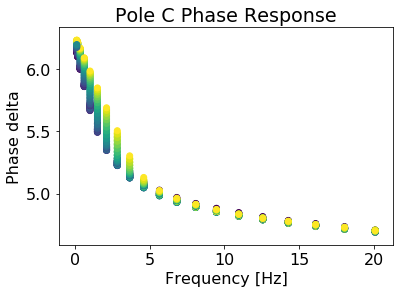

In [18]:
for pole in poles:
    plt.scatter(freq_data[pole]['freq'], freq_data[pole]['phase_delta'], c=freq_data[pole]['hx_amp'])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase delta')
    plt.title('Pole {} Phase Response'.format(poles_dict[pole]))
    plt.savefig(os.path.join(out_folder, 'Phase_response_pole{}.png'.format(poles_dict[pole])))

### Fit the amplitude

Pole A
[0.53725788 0.91138421]
L:0.5372578782640618
R:0.9113842112873987
Pole B
[0.56941909 0.98554963]
L:0.5694190937531782
R:0.985549629583188
Pole C
[0.56813972 1.0579424 ]
L:0.5681397224460104
R:1.0579424021364479


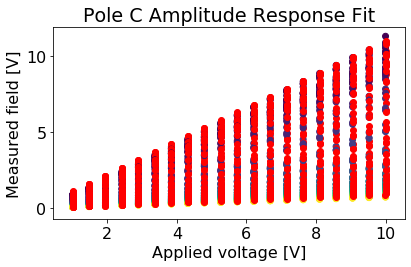

In [65]:
amp_inv_functions = []
LR_coeffs = []
for pole in poles:
    print('Pole {}'.format(poles_dict[pole]))
    hp= freq_data[pole]['hp_amp'].values
    f = freq_data[pole]['freq'].values
    hx = freq_data[pole]['hx_amp'].values

    x =np.hstack((f[:, np.newaxis], hx[:, np.newaxis]))


    amp_fitting = lambda x, L, R: x[:, 1]/np.sqrt((L*x[:, 0])**2+R**2)
    popt, perr = curve_fit(amp_fitting, x, hp)#, p0 = [0.01, 0.01], bounds=[[0, 0], [100, 100]])#, max_nfev=10000, diff_step=0.001)
    print(popt)
    amp_fun = lambda x: amp_fitting(x, *popt)
    L, R = popt[0], popt[1]
    print('L:{}\nR:{}'.format(L, R))
    amp_inv_fun = lambda amp, freq, L=L, R=R: amp*np.sqrt((L*freq)**2+R**2)
    amp_inv_functions.append(amp_inv_fun)
    LR_coeffs.append(popt.copy())

    plt.scatter(hx, hp, c=f)
    plt.scatter(hx, amp_fun(x), c='red')

    plt.xlabel('Applied voltage [V]')
    plt.ylabel('Measured field [V]')
    plt.title('Pole {} Amplitude Response Fit'.format(poles_dict[pole]))
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder, 'Amplitude_response_pole{}_fit.png'.format(poles_dict[pole])))

### Fit the phase

Lag: -0.005328416268000069
Lag: -0.005207301995446559
Lag: -0.004640173475753932


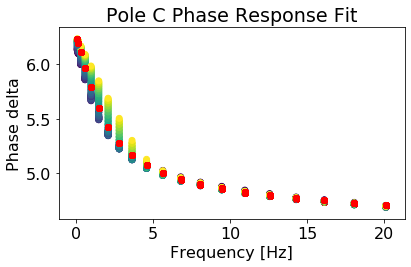

In [66]:
delta_phase_functions = []
lags = []
for pole in poles:
    phase_delta = freq_data[pole]['phase_delta'].values
    f = freq_data[pole]['freq'].values
    hx = freq_data[pole]['hx_amp']

    delta_phase_fit = lambda x, lag: 2*np.pi-np.arctan(x*L/R)+lag*x
    popt, perr = curve_fit(delta_phase_fit, f, phase_delta)
    lag = popt[0]
    print('Lag: {}'.format(lag))
    lags.append(lag.copy())
    delta_phase_fun = lambda f, lag=lag: delta_phase_fit(f, lag)
    delta_phase_functions.append(delta_phase_fun)
    

    plt.scatter(f, phase_delta, c=hx)
    plt.scatter(f, delta_phase_fun(f), c='red')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase delta')
    plt.title('Pole {} Phase Response Fit'.format(poles_dict[pole]))
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder, 'Phase_response_pole{}_fit.png'.format(poles_dict[pole])))

# Testing the fit

### Import and plot the signal

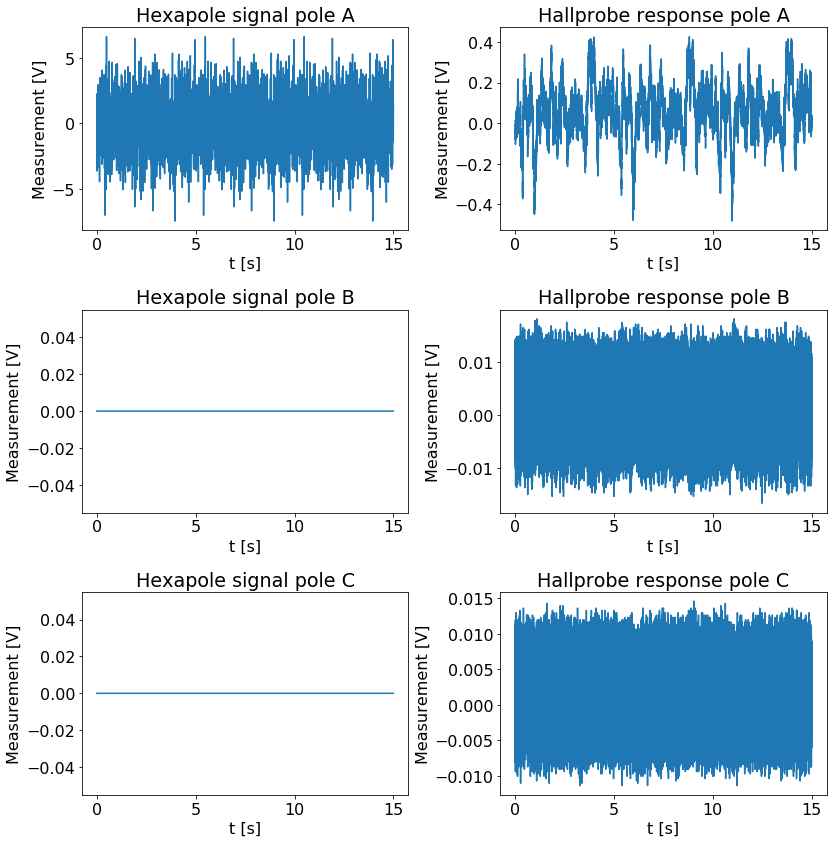

In [67]:
# get the test signal
test_num=0
with h5py.File(file_path, 'r') as f:
    hp_signal = f['test_response/test{}/hallprobe/data'.format(test_num)][:]
    hp_signal[:, 0] -= hp_signal[0, 0]
    hx_signal = f['test_response/test{}/hexapole/data'.format(test_num)][:]
    hx_signal[:, 0] -= hx_signal[0, 0]

fig = plt.figure(figsize=(12, 12))
for pole in poles:
    plt.subplot(3, 2, 2*pole+1)
    plt.plot(hx_signal[:, 0], hx_signal[:, pole+1])
    plt.xlabel('t [s]')
    plt.ylabel('Measurement [V]')
    plt.title('Hexapole signal pole {}'.format(poles_dict[pole]))

    plt.subplot(3, 2, 2*pole+2)
    plt.title('Hallprobe response pole {}'.format(poles_dict[pole]))
    plt.plot(hp_signal[:, 0], hp_signal[:, pole+1])
    plt.xlabel('t [s]')
    plt.ylabel('Measurement [V]')

plt.tight_layout()

### Try to reconstruct the hexapole signal from the hallprobe

In [50]:
def get_required_input_pole(hp_signal, hyst_fun, amp_fun, phase_fun, cutoff_freq=100):
    """Gets the required hex signal given the measured/desired hp signal for a given pole. 
    hp_signal is expected to be nx2 array with first column being time.
    Returns the hx_signal"""
    assert hp_signal.shape[1] == 2
    t = hp_signal[:, 0] 
    signal = hp_signal[:, 1]
    timestep = t[1] - t[0]
    
    # first invert the hysteresis
    signal_nohyst = hyst_fun(signal)
    # do fft on the signal and extract the frequencies
    n = signal_nohyst.shape[0]
    fft = np.fft.rfft(signal_nohyst) / (n / 2)
    fft_phase = np.angle(fft)
    fft_amp = np.absolute(fft)
    freq = np.fft.rfftfreq(n, d=timestep)
    
    # kill all of the ampilitudes of signals higher than 100Hz
    fft_amp[freq>cutoff_freq] = 0
    
    # apply the amplitude and phase functions
    hx_amp = amp_fun(fft_amp, freq)
    hx_phase = fft_phase + phase_fun(freq)
    
    # reconstruct the signal
    hx_fft = hx_amp*np.exp(1j*hx_phase)
    hx_signal = np.fft.irfft(hx_fft, n=n) * (n/2)
    
    return hx_signal

def get_required_input(hp_signal, hyst_functions, amp_functions, phase_functions, cutoff_freq=100):
    """Gets the required hex signal given the measured/desired hp signal for a given pole. 
    hp_signal is expected to be nx4 array with first column being time, and the other 3 being
    the desired signal for the given time
    Returns the hx_signal in the same shape"""
    
    out_signal = hp_signal.copy()
    for pole in poles:
        out_signal[:, pole+1] = get_required_input_pole(hp_signal[:, [0, pole+1]], 
                                                        hyst_fun = hyst_functions[pole], 
                                                        amp_fun = amp_functions[pole], 
                                                        phase_fun = phase_functions[pole], 
                                                        cutoff_freq=cutoff_freq)
    # there is a pi difference not accounted for
    out_signal[:, 1:] *= -1
    return out_signal

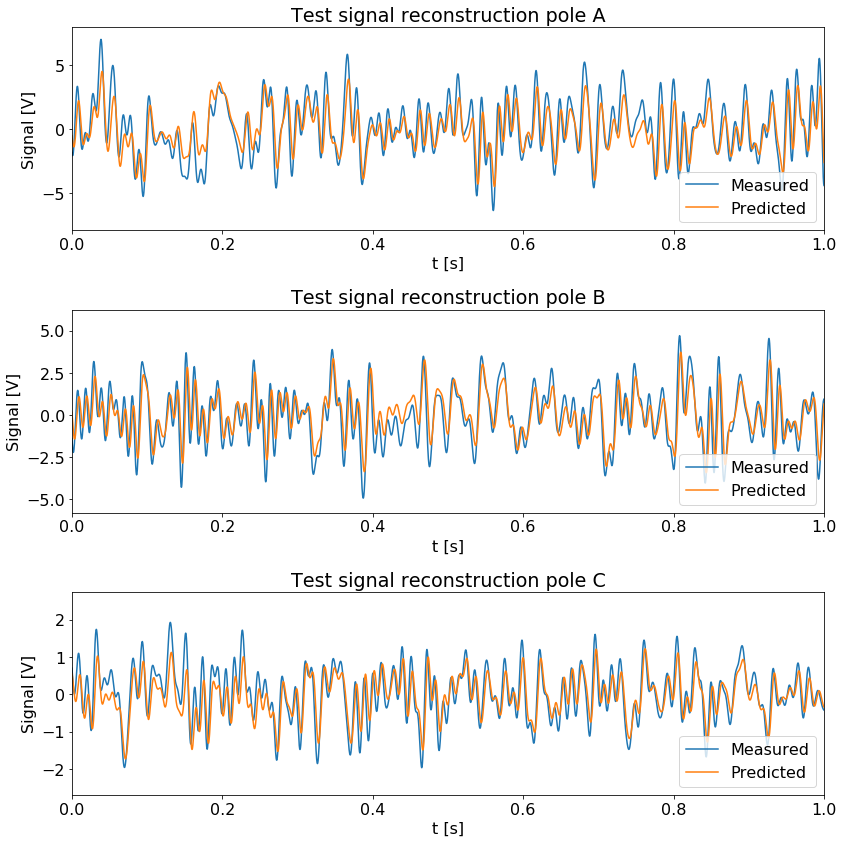

In [54]:
inverted_hx = get_required_input(hp_signal, 
                                 hyst_functions,
                                amp_inv_functions,
                                delta_phase_functions)

fig = plt.figure(figsize=(12, 12))
for pole in poles:
    ax = plt.subplot(3, 1, pole+1)
    ax.plot(hx_signal[:, 0], hx_signal[:, pole+1], label='Measured')
    ax.plot(inverted_hx[:, 0], inverted_hx[:, pole+1], label='Predicted')
    plt.legend(loc='lower right')
    plt.xlabel('t [s]')
    plt.ylabel('Signal [V]')
    plt.title('Test signal reconstruction pole {}'.format(poles_dict[pole]))
    plt.xlim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'Test_signal_reconstruction.png'), dpi=300)

# Save the results

In [60]:
results = {
    'Poly_coeff': hyst_coeffs, 
    'LR_coeff': LR_coeffs,
    'Lags': lags
}
# for pole in poles:
#     results['LRpole'+str(pole)] = LR_coeffs[pole]
#     results['Lag'+str(pole)] = lags[pole]
print(results)
import pickle

with open(os.path.join(out_folder,'coefficients.p'), 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

{'Poly_coeff': [array([-0.11431185,  0.        ,  0.15528954,  0.        , -0.29578994,
        0.        , -1.83921101,  0.        ]), array([-0.1364662 ,  0.        ,  0.1893485 ,  0.        , -0.32750949,
        0.        , -1.88586746,  0.        ]), array([-0.13754719,  0.        ,  0.17260889,  0.        , -0.35769612,
        0.        , -1.91392444,  0.        ])], 'LR_coeff': [array([0.53725788, 0.91138421]), array([0.56941909, 0.98554963]), array([0.56813972, 1.0579424 ])], 'Lags': [-0.005328416268000069, -0.005207301995446559, -0.004640173475753932]}


### Make sure you can read

In [61]:
with open(os.path.join(out_folder,'coefficients.p'), 'rb') as fp:
    print(pickle.load(fp))

{'Poly_coeff': [array([-0.11431185,  0.        ,  0.15528954,  0.        , -0.29578994,
        0.        , -1.83921101,  0.        ]), array([-0.1364662 ,  0.        ,  0.1893485 ,  0.        , -0.32750949,
        0.        , -1.88586746,  0.        ]), array([-0.13754719,  0.        ,  0.17260889,  0.        , -0.35769612,
        0.        , -1.91392444,  0.        ])], 'LR_coeff': [array([0.53725788, 0.91138421]), array([0.56941909, 0.98554963]), array([0.56813972, 1.0579424 ])], 'Lags': [-0.005328416268000069, -0.005207301995446559, -0.004640173475753932]}
